In [3]:
# Check that weighted cca is coherent
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_CCA
%aimport sample_gen
from scipy.stats import multivariate_normal
from collections import defaultdict
from scipy.linalg import sqrtm

Populating the interactive namespace from numpy and matplotlib


In [21]:
def variance(x,w=None):
    if w is None:
        w = np.ones(x.shape)
    
    x_mean = (w*x).sum()/w.sum()
    
    return (w*((x-x_mean)**2)).sum()/(w.sum()-1)

def covariance(x,y,w=None):
    if w is None:
        w = np.ones(x.shape)
    
    x_mean = (w*x).sum()/w.sum()
    y_mean = (w*y).sum()/w.sum()
    
    return (w*(x-x_mean)*(y-y.mean())).sum()/(w.sum()-1)

def correlation(x,y,w=None):
    if w is None:
        w = np.ones(x.shape)
        
    return covariance(x,y,w=w)/sqrt(variance(x,w=w))/sqrt(variance(y,w=w))

# Generating test set.

$$ \newcommand{\R}{\mathbb{R}} $$

$$ X = \{ x_1, x_2, ..., x_n \mid x \in \R^k \} $$
$$ Y = \{ y_1, y_2, ..., y_n \mid y \in \R^k \} $$

$$
X = 
\begin{bmatrix}
    x_{11} && x_{12} && \dots && x_{1k} \\
    x_{21} && x_{22} && \dots && x_{2k} \\
    \vdots && \vdots && \ddots && \vdots \\
    x_{n1} && x_{n2} && \dots && x_{nk} \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
    y_{11} && y_{12} && \dots && y_{1k} \\
    y_{21} && y_{22} && \dots && y_{2k} \\
    \vdots && \vdots && \ddots && \vdots \\
    y_{n1} && y_{n2} && \dots && y_{nk} \\
\end{bmatrix}
$$

$$ k = 10 $$
$$ n = 1000 $$


In [44]:
k = 10
n = 1000
d1 = sample_gen.create_distribution(k,mean_std_scale=0.3,std=1)
d2 = sample_gen.create_distribution(k,mean_std_scale=1,std=2,std_scale=0.1)
X = d1.rvs(n)
Y = X+d2.rvs(n)
#w = np.abs( ( ((X-X.mean(axis=0))**2).sum(axis=1) ) )
w = abs( np.random.normal(1,0.3,size=X.shape[0]) )

# outliers
outliers_portion = 0.1
X_outliers = np.random.multivariate_normal(X.mean(axis=0), np.cov(X,rowvar=False)*10,size=int(X.shape[0]*outliers_portion))
Y_outliers = np.random.multivariate_normal(X.mean(axis=0), np.cov(X,rowvar=False)*10,size=int(X.shape[0]*outliers_portion))
outliers_weights = np.abs( np.random.normal(w.mean()*0.2,w.std()*0.5,size=X_outliers.shape[0]) )

X = np.concatenate( (X,X_outliers) )
Y = np.concatenate( (Y,Y_outliers) )
w = np.concatenate( (w,outliers_weights) )

ids = np.arange(0,X.shape[0])
np.random.shuffle(ids)
X = X[ids]
Y = Y[ids]
w = w[ids]

del d1
del d2

# Yield of CCA

$$ A \in \R^{k \times k} $$
$$ B \in \R^{k \times k} $$

$$ U = A^T X^T = \{u_1, u_2, ..., u_k\ \mid u_i = (col_iA)^T X \} $$
$$ V = B^T Y^T = \{v_1, v_2, ..., v_k\ \mid v_i = (col_iB)^T Y \} $$


# CCA CALC

# Push data

In [6]:
# Paramters
use_weights = True
x=X
y=Y

# Push

n = np.shape(x)[0]

x_sum = np.sum(x,axis=0)[:,np.newaxis]
y_sum = np.sum(y,axis=0)[:,np.newaxis]
xy_sum = np.transpose(x) @ y
xx_sum = np.transpose(x) @ x
yy_sum = np.transpose(y) @ y

if use_weights:
    xy_sum_w = np.transpose(x) @ (y*w[:,np.newaxis])
    xx_sum_w = np.transpose(x) @ (x*w[:,np.newaxis])
    yy_sum_w = np.transpose(y) @ (y*w[:,np.newaxis])
    x_sum_w  = np.sum(x*w[:,np.newaxis],axis=0)[:,np.newaxis]
    y_sum_w  = np.sum(y*w[:,np.newaxis],axis=0)[:,np.newaxis]
    w_sum = w.sum()
else:
    # assuming all weights are 1
    xy_sum_w = np.transpose(x) @ y
    xx_sum_w = np.transpose(x) @ x
    yy_sum_w = np.transpose(y) @ y
    x_sum_w  = np.sum(x,axis=0)[:,np.newaxis]
    y_sum_w  = np.sum(y,axis=0)[:,np.newaxis]
    w_sum = np.shape(x)[0]

# Calc operation

In [7]:
# xx_cov = new_CCA.calc_covariance(xx_sum,x_sum,x_sum,n)
# xy_cov = new_CCA.calc_covariance(xy_sum,x_sum,y_sum,n)
# yy_cov = new_CCA.calc_covariance(yy_sum,y_sum,y_sum,n)

xx_cov = new_CCA.calc_covariance_weighted(xx_sum_w,x_sum,x_sum_w,x_sum,x_sum_w,n,w_sum)
xy_cov = new_CCA.calc_covariance_weighted(xy_sum_w,x_sum,x_sum_w,y_sum,y_sum_w,n,w_sum)
yy_cov = new_CCA.calc_covariance_weighted(yy_sum_w,y_sum,y_sum_w,y_sum,y_sum_w,n,w_sum)

xx_cov_sqrt_inv = np.linalg.inv( sqrtm(xx_cov) )
yy_cov_sqrt_inv = np.linalg.inv( sqrtm(yy_cov) )

u_mat = xx_cov_sqrt_inv @ xy_cov @ np.linalg.inv(yy_cov) @ xy_cov.T @ xx_cov_sqrt_inv
u_eigvals,u_eigvecs = np.linalg.eig(u_mat)

v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

# Sort eigenvectors by their eigenvalues
# The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
u = u_eigvecs.T[sorted([i for i in range(len(u_eigvals))], key=lambda x: -u_eigvals[x])]
v = v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

A = (u @ xx_cov_sqrt_inv).T
B = (v @ yy_cov_sqrt_inv).T

        
# fix possible result for negarive correlation    
# reg = np.array( [ new_CCA.calc_linear_regression(n,A[:,i],B[:,i],x_sum,y_sum,xy_sum,xx_sum ) for i in range(k) ] )

#A = A*reg[:,1]

U = A.T @ X.T
V = B.T @ Y.T

# Unweighted covariance

$$\newcommand\conj[1]{\bar{#1}}$$
$$\newcommand\mean[1]{\bar{#1}}$$

$$ \sum_i^n (x_i-\mean x)(y_i-\mean y) $$
$$ \sum_i^n [ x_i y_i -x_i \mean y -y_i \mean x + \mean x \mean y ] $$
$$ \sum_i^n x_i y_i - \mean y \sum_i^n x_i - \mean x \sum_i^n y_i + n \mean x \mean y $$
$$ \sum_i^n x_i y_i - n \mean y \mean x - n \mean x \mean y + n \mean x \mean y $$
$$ \sum_i^n x_i y_i - n \mean y \mean x $$

# Weighted covariance

$$\newcommand\mean[1]{\bar{#1}}$$

$$ \sum_i^n w_i(x_i-\mean x)(y_i-\mean y) $$
$$ \sum_i^n [ w_i x_i y_i - w_i x_i \mean y - w_i y_i \mean x + w_i \mean x \mean y ] $$
$$ \sum_i^n w_i x_i y_i - \mean y \sum_i^n w_i x_i - \mean x \sum_i^n w_i y_i + \mean x \mean y \sum_i^n w_i $$
$$ \sum_i^n w_i x_i y_i - \mean y \mean x \sum w_i - \mean x \mean y \sum w_i + \mean x \mean y \sum_i^n w_i $$
$$ \sum_i^n w_i x_i y_i - \mean x \mean y \sum_i^n w_i $$

## Generally

$$\newcommand\mean[1]{\bar{#1}}$$
$$\newcommand\vectorof[1]{\overrightarrow{#1}}$$

$$ X^T W Y - X^T w \mean{Y}^T - \mean{X} w^T Y + \mean{X} \mean{Y}^T \mean{w}n $$

In [66]:
# Correlation function
def calc_covariance_weighted_old(xy_sum_w,x_sum,x_sum_w,y_sum,y_sum_w,n,w_sum):
    """
    calculate weighted covariance matrix of 2 variables
    """
    return (xy_sum_w - x_sum_w @ (y_sum_w/w_sum).T - (x_sum_w/w_sum) @ y_sum_w.T + (x_sum_w/w_sum) @ (y_sum_w/w_sum).T*w_sum)/(w_sum-1)

def calc_covariance_weighted(xy_sum_w,x_sum,x_sum_w,y_sum,y_sum_w,n,w_sum):
    """
    calculate weighted covariance matrix of 2 variables
    """
    return (xy_sum_w - (x_sum_w/w_sum) @ (y_sum_w/w_sum).T*w_sum)/(w_sum-1)


In [67]:
calc_covariance_weighted    (xy_sum_w,x_sum,x_sum_w,y_sum,y_sum_w,n,w_sum)/\
calc_covariance_weighted_old(xy_sum_w,x_sum,x_sum_w,y_sum,y_sum_w,n,w_sum)

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [80]:
# weighted
cca = new_CCA.CCA(k)
cca.push(X,Y,w=w)
A,B, reg = cca.calc()
U = A.T @ X.T
V = B.T @ Y.T

In [78]:
# standard
cca = new_CCA.CCA(k)
cca.push(X,Y)
A,B, reg = cca.calc()
U = A.T @ X.T
V = B.T @ Y.T

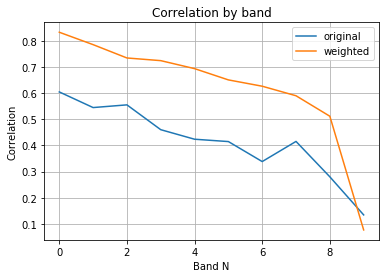

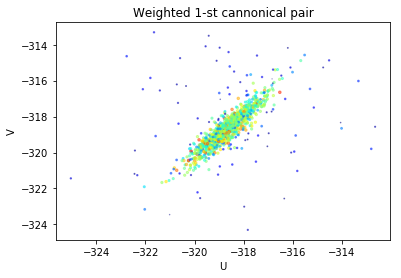

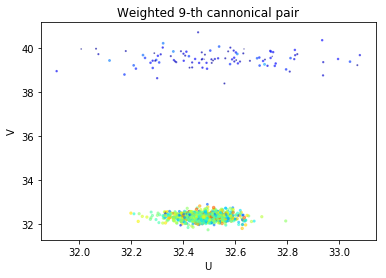

In [81]:
title("Correlation by band")
plot( np.array( [abs(correlation(U[i],V[i])) for i in range(k)] ), label='original');
plot( np.array( [abs(correlation(U[i],V[i],w=w)) for i in range(k)] ), label='weighted');
xlabel("Band N")
ylabel("Correlation");
legend();
grid();
show();

title("Weighted 1-st cannonical pair")
scatter( (U+reg[:,0,np.newaxis])[0], V[0],  s=sqrt(w)*5, c=w,alpha=0.5,cmap='jet');
xlabel("U");
ylabel("V")
show();
title("Weighted 9-th cannonical pair")
scatter( (U+reg[:,0,np.newaxis])[9], V[9],  s=sqrt(w)*5, c=w,alpha=0.5,cmap='jet');
xlabel("U");
ylabel("V")
show();

In [53]:
(w*(U[0]-V[0])**2).sum()/w.sum()

9375.2086198785692

In [54]:
((U[0]-V[0])**2).mean()

9369.3232907329602

In [75]:
from sklearn.linear_model import LinearRegression

skreg = LinearRegression(fit_intercept=True)

skreg.fit(U[0,:,np.newaxis],V[0],w)
print( skreg.coef_ )
print( skreg.intercept_ )

[ 1.]
-12.275791043
